In [16]:
import numpy as np
import pandas as pd
import librosa
import librosa.display as ld
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from config import *
from classifier import *

# Data Analysis
Reading CSV that contains audio file to instrument label mapping.

In [17]:
df = pd.read_csv('instruments.csv')
df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


Getting the distribution of recordings for each type of instrument

In [18]:
instrument_types = df['label'].value_counts()
print(instrument_types)

Hi-hat              30
Cello               30
Saxophone           30
Flute               30
Violin_or_fiddle    30
Clarinet            30
Snare_drum          30
Double_bass         30
Acoustic_guitar     30
Bass_drum           30
Name: label, dtype: int64


In [19]:
instruments = df['label'].unique()
print(instruments)

['Saxophone' 'Violin_or_fiddle' 'Hi-hat' 'Snare_drum' 'Acoustic_guitar'
 'Double_bass' 'Cello' 'Bass_drum' 'Flute' 'Clarinet']


Extracting a sample MFCC, STFT & Mel Spectogram for each instrument type & plotting it.

In [20]:
def extract_features(file):
    signal, sr = librosa.load(file, Config.sr)
    return librosa.feature.mfcc(y=signal, sr=sr),\
      librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max),\
      librosa.power_to_db(librosa.feature.melspectrogram(signal))

In [21]:
mfccs = []
stfts = []
mels = []
for instrument in instruments:
    file = f'wavfiles/{df[df.label == instrument].iloc[0,0]}'
    mfcc, stft, mel = extract_features(file)
    mfccs.append(mfcc)
    stfts.append(stft)
    mels.append(mel)

In [22]:
def plot(title, data, y_scale='log'):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(30,10))
    fig.suptitle(title, size=16)
    for i, instrument in enumerate(instruments):
        row = 0 if i < 5 else 1
        col = i % 5
        axis = ax[row, col]
        axis.set(title = f'{instrument}')
        axis.get_xaxis().set_visible(True)
        axis.get_yaxis().set_visible(True)
        i = librosa.display.specshow(data[i], x_axis='time', y_axis=y_scale, ax=ax[row, col])#, cmap='Blues'
    plt.colorbar(i, ax=ax, format='%+3.f')

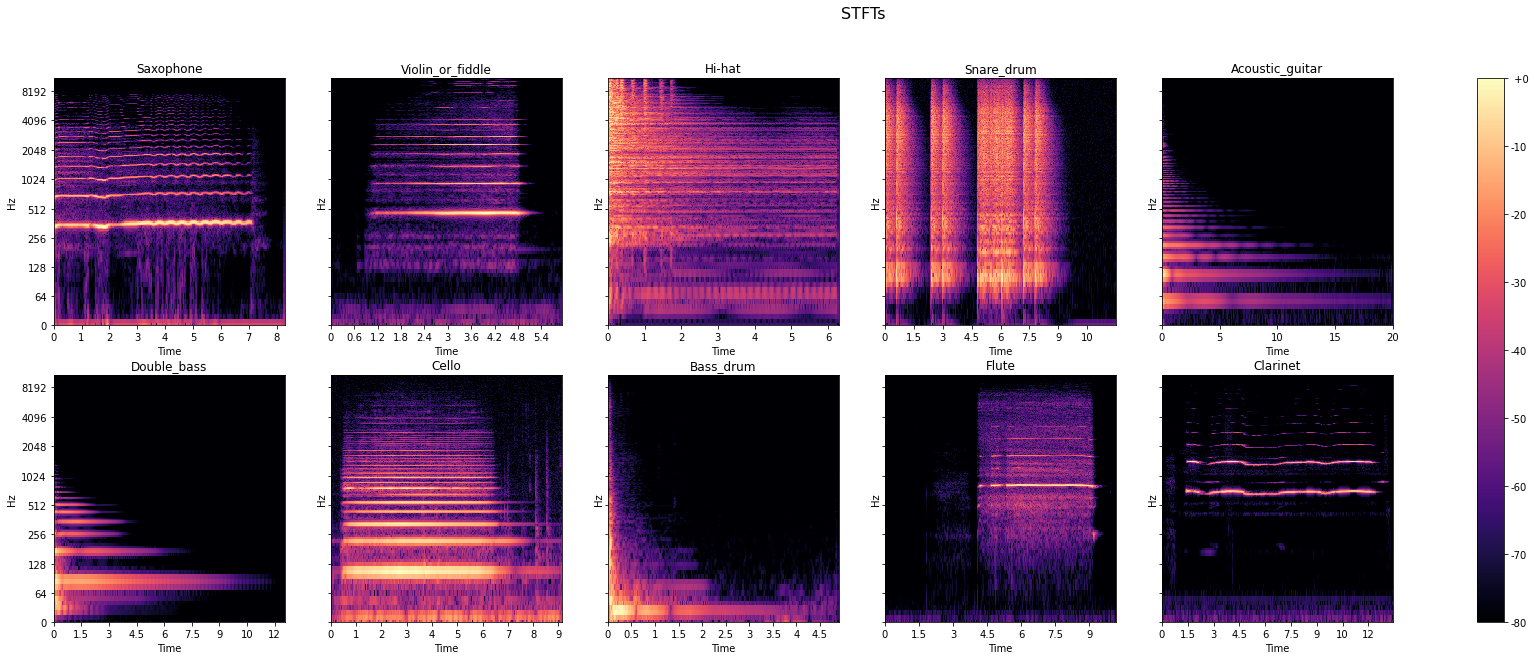

In [23]:
plot('STFTs', stfts)

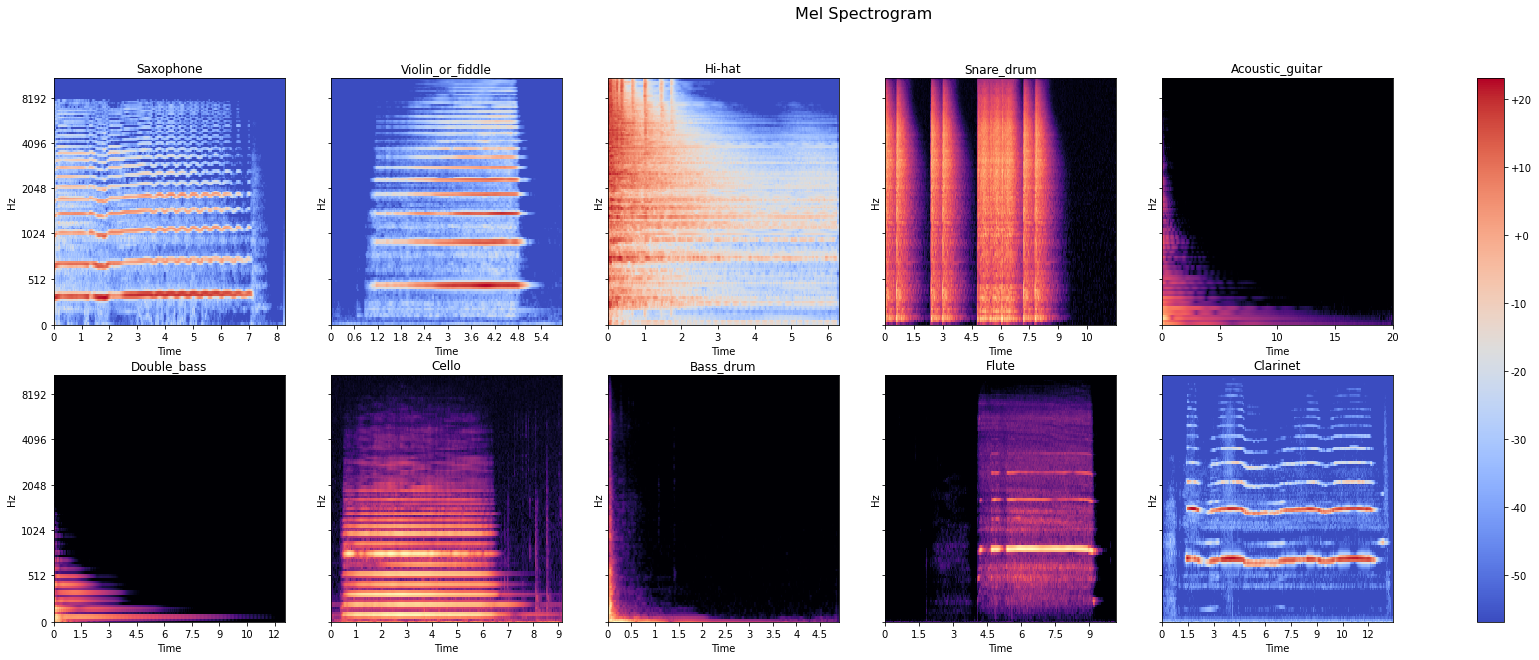

In [24]:
plot('Mel Spectrogram', mels, y_scale='mel')

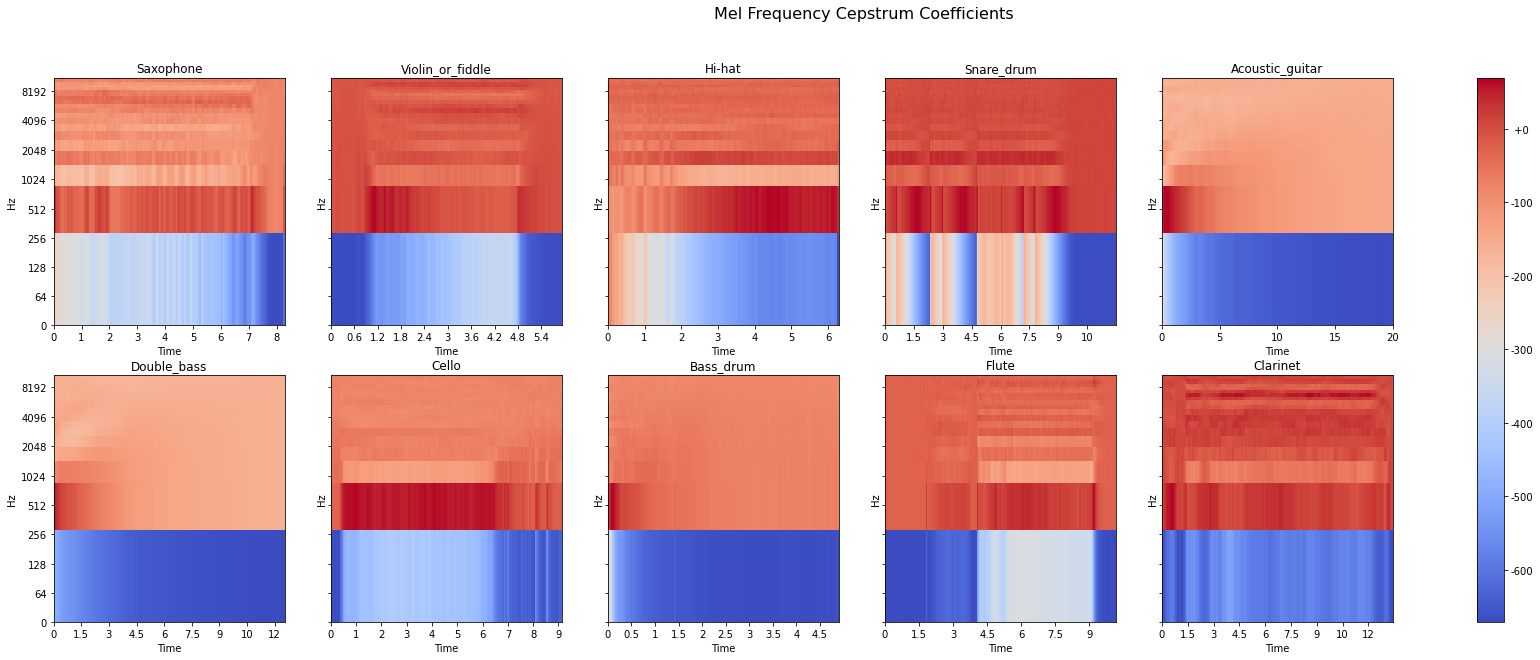

In [25]:
plot('Mel Frequency Cepstrum Coefficients', mfccs)

# Machine Learning
Classifier class with ability to configure no. of samples and features used for classification.

Internally uses Naive Bayes as the baseline followed by SVM for better performance.

Features are extracted before sampling as audio feature extraction is slow.

In [26]:
def _extract_mfcc(signal, sr):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr)
    aver = np.mean(mfccs, axis = 1)
    feature = aver.reshape(20)
    return feature

def _extract_melspectrogram(signal, sr):
    spectrogram = librosa.feature.melspectrogram(signal)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    spectrogram = np.mean(spectrogram, axis=1)
    return spectrogram

def extract(row):
    signal, sr = librosa.load(f'wavfiles/{row[0]}', Config.sr)
    x1 = _extract_mfcc(signal, sr)
    x2 = _extract_melspectrogram(signal, sr)
    return x1,x2

df['mfcc'], df['melspectrogram'] = zip(*df.apply(extract, axis=1))
df.iloc[:5,:]

,fname,label,mfcc,melspectrogram
0,5388d14d.wav,Saxophone,"(-272.33786, 58.306755, -47.943787, 7.301422, ...","(-2.7999992, -25.17658, -28.684496, -28.723795..."
1,c685f05f.wav,Saxophone,"(-287.33243, 101.56712, -29.987404, 20.03815, ...","(2.3896997, -17.04163, -16.49534, -13.215973, ..."
2,36d20ab5.wav,Saxophone,"(-238.68503, 153.41728, -26.39078, 26.09202, 1...","(-9.527214, -15.543957, 10.565876, 24.367052, ..."
3,d6665734.wav,Saxophone,"(-351.35153, 166.21623, -41.64548, 4.0183616, ...","(-33.780457, -23.965872, -6.249142, 3.50676, 5..."
4,7352e28f.wav,Saxophone,"(-315.89813, 146.70885, -78.09529, -38.58948, ...","(-33.47275, -35.72336, -40.216938, -40.49374, ..."


Testing the classifier with different audio features & sample sizes.

In [27]:
samples = [300, 600, 1000, 2000]
scores_dict = {}

dfRes = pd.DataFrame(columns=['Feature', 'Model', 'Sample', 'Accuracy'])


for sample in samples:
    for feature, pca_comp in zip(['mfcc', 'melspectrogram'], [15, 40]):
        for model in ['gnb', 'svc']:
            classifier = InstrumentClassifier(sample, feature = feature, model=model, pca_components=pca_comp)
            classifier.extract_features(df)
            classifier.fit()
            score = classifier.perf()
            dfRes = dfRes.append({'Feature':classifier.feature, 'Model':classifier.model, 'Sample':classifier.n_samples, 'Accuracy':score}, ignore_index=True)

Tabulating the results

In [28]:
dfRes\
    .sort_values(by=['Model', 'Feature', 'Sample'])\
    .pivot(index=['Sample'], columns=['Model', 'Feature'],values=['Accuracy'])

Accuracy                                   
Model              gnb                      svc          
Feature melspectrogram      mfcc melspectrogram      mfcc
Sample                                                   
300           0.600000  0.626667       0.706667  0.720000
600           0.713333  0.746667       0.900000  0.913333
1000          0.704000  0.752000       0.924000  0.908000
2000          0.756000  0.782000       0.974000  0.930000

Plotting accuracy for different samples, features & models

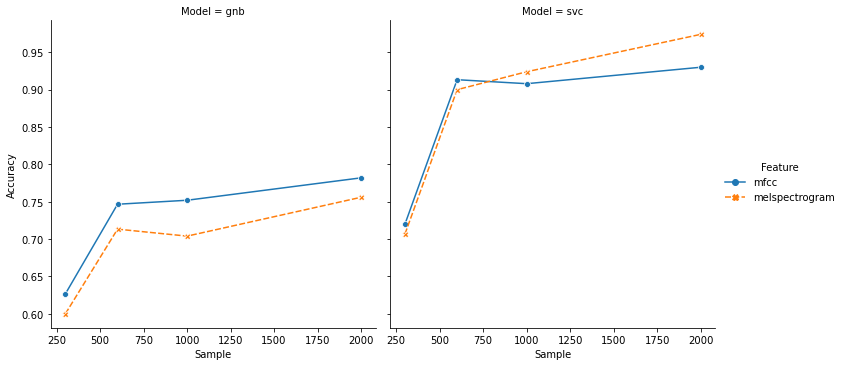

In [29]:
sns.relplot(data=dfRes, x="Sample", y="Accuracy", hue="Feature", style="Feature", col="Model", kind="line", markers=True)

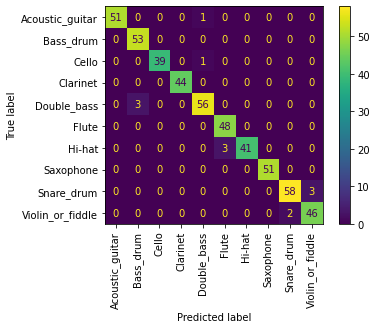

In [30]:
classifier = InstrumentClassifier(2000, feature = 'melspectrogram', model='svc', pca_components=40)
classifier.extract_features(df)
classifier.fit()
plot_confusion_matrix(classifier.pipeline, classifier.x_test, classifier.y_test, xticks_rotation='vertical')  
plt.show()

In [31]:
classifier.predict()
report = classification_report(classifier.y_test, classifier.y_pred)
print(report)

                  precision    recall  f1-score   support

 Acoustic_guitar       1.00      0.98      0.99        52
       Bass_drum       0.95      1.00      0.97        53
           Cello       1.00      0.97      0.99        40
        Clarinet       1.00      1.00      1.00        44
     Double_bass       0.97      0.95      0.96        59
           Flute       0.94      1.00      0.97        48
          Hi-hat       1.00      0.93      0.96        44
       Saxophone       1.00      1.00      1.00        51
      Snare_drum       0.97      0.95      0.96        61
Violin_or_fiddle       0.94      0.96      0.95        48

        accuracy                           0.97       500
       macro avg       0.98      0.97      0.97       500
    weighted avg       0.97      0.97      0.97       500

